In [1]:
%cd /content/drive/MyDrive/behavox/

/content/drive/MyDrive/behavox


In [2]:
!pip install transformers
!pip install sentencepiece
!pip install sentence-transformers


     |████████████████████████████████| 2.3MB 7.4MB/s 
     |████████████████████████████████| 3.3MB 51.2MB/s 
     |████████████████████████████████| 901kB 48.4MB/s 
     |████████████████████████████████| 1.2MB 7.5MB/s 
     |████████████████████████████████| 81kB 5.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-cp37-none-any.whl size=123339 sha256=b05f43a1ac3fefda0f9c20b9a0fc996d8d8105564f98d72dd0a8237b529a474c
  Stored in directory: /root/.cache/pip/wheels/0f/06/f7/faaa96fdda87462b4fd5c47b343340e9d5531ef70d0eef8242
Successfully built sentence-transformers


In [49]:
import pandas as pd
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup, XLNetForSequenceClassification
import collections
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
import seaborn as sns
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams
import json

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
import statistics
import pprint

% matplotlib inline

In [4]:
def check_gpu_availabilty():
  if torch.cuda.is_available():        
      device = torch.device("cuda")
      print('There are %d GPU(s) available.' % torch.cuda.device_count())
      print('We will use the GPU:', torch.cuda.get_device_name(0))
  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")
  return device

def read_train_test(train_file_name, test_file_name):
  train_df = pd.read_csv(f'dataset/{train_file_name}.csv')
  test_df = pd.read_csv(f'dataset/{test_file_name}.csv')
  return train_df,test_df

def get_sents_from_df(df,sent_column):
  return df[sent_column].values

def get_labels_from_df(df,label_column):
  return df[label_column].values

def get_labels_map(df):
    labels = sorted(df['label'].unique().tolist())
    label2id = collections.OrderedDict(zip(labels, range(len(labels))))
    return label2id

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def get_tokenizer(pre_trained_model):
  print('Loading  tokenizer...')
  tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
  return tokenizer

def get_max_len(tokenizer, sentences):
  max_len = 0
  for sent in sentences:
      input_ids = tokenizer.encode(sent, add_special_tokens=True)
      max_len = max(max_len, len(input_ids))
  return max_len

def encode_data(tokenizer, sentences, labels, max_len):
  input_ids = []
  attention_masks = []

  for sent in sentences:
      encoded_dict = tokenizer.encode_plus(
                          sent,
                          add_special_tokens = True,
                          max_length = max_len,
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_tensors = 'pt',
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks, labels

def get_train_test_split(input_ids, attention_masks, labels, split_size = 0.9):
  dataset = TensorDataset(input_ids, attention_masks, labels)
  train_size = int(split_size * len(dataset))
  val_size = len(dataset) - train_size
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
  return train_dataset, val_dataset

def create_dataloader(dataset, batch_size, Sampler):
  dataloader = DataLoader(
            dataset,
            sampler = Sampler(dataset),
            batch_size = batch_size
        )
  return dataloader

def build_model(task, pre_trained_model, classes, epochs=30, lr=2e-5, eps=1e-8, num_warmup_steps = 0):
  model = task.from_pretrained(
      pre_trained_model,
      num_labels = len(classes),
      output_attentions = False,
      output_hidden_states = False,
  )
  model.cuda()
  optimizer = AdamW(model.parameters(),
                  lr = lr,
                  eps = eps
                )
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = num_warmup_steps,
                                            num_training_steps = total_steps)
  
  return model, optimizer, scheduler

def train_model(seed_val, epochs, model, train_dataloader, validation_dataloader, device):
  seed_val = 42
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  training_stats = []
  total_t0 = time.time()

  for epoch_i in range(0, epochs):
      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')
      t0 = time.time()
      total_train_loss = 0
      model.train()

      for step, batch in enumerate(train_dataloader):
          if step % 40 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          model.zero_grad()
          result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=True)
          loss = result.loss
          logits = result.logits
          total_train_loss += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()

      avg_train_loss = total_train_loss / len(train_dataloader)
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))
      print("")
      print("Running Validation...")

      t0 = time.time()
      model.eval()
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0
      for batch in validation_dataloader:
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          with torch.no_grad():
              result = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)
          loss = result.loss
          logits = result.logits
          total_eval_loss += loss.item()
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          total_eval_accuracy += flat_accuracy(logits, label_ids)

      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      avg_val_loss = total_eval_loss / len(validation_dataloader)

      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return model, training_stats

def predict(model, prediction_dataloader, device):
  model.eval() 
  predictions , top_pred, true_labels = [], [], []
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)
    logits = result.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    top_pred.extend(np.argmax(softmax(logits, axis=1),axis=1))
    true_labels.extend(label_ids)
    predictions.extend(softmax(logits, axis=1))
  return top_pred, true_labels, predictions

def inference(model, prediction_dataloader, device):
  model.eval() 
  predictions , top_pred = [], []
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch
    with torch.no_grad():
        result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)
    logits = result.logits
    logits = logits.detach().cpu().numpy()
    top_pred.extend(np.argmax(softmax(logits, axis=1),axis=1))
    predictions.extend(softmax(logits, axis=1))
  return top_pred, predictions
  
def get_cr_cm(gt,pred):
    print(classification_report(gt,pred))
    # print(confusion_matrix(gt,pred))
    gt_series = pd.Series(gt)
    pred_series = pd.Series(pred)
    cm = pd.crosstab(gt_series, pred_series, rownames=['TRUE'], colnames=['PREDICTED'],margins=True)
    return cm

In [7]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
input_txt = "Text data"
tokenizer.encode_plus
encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=16, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=True)
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Execute the code

In [ ]:
device = check_gpu_availabilty()
print('\n')

df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

msk = np.random.rand(len(df)) < 0.9
train_df = df[msk]
test_df = df[~msk]

train_sents = get_sents_from_df(train_df,"sentence")
train_labels = get_labels_from_df(train_df, "label")
print("Number of training examples sentences : ", len(train_sents))
print("Number of training labels : ", len(train_labels))
print('\n')

test_sents = get_sents_from_df(test_df,"sentence")
test_labels = get_labels_from_df(test_df, "label")
print("Number of test examples sentences : ", len(test_sents))
print("Number of test labels : ", len(test_labels))
print('\n')

pre_trained_model = "xlnet-base-cased"
tokenizer = get_tokenizer(pre_trained_model)

label2id = get_labels_map(train_df)
classes = list(label2id.keys())
labels = [label2id[l] for l in train_labels]
print("Number of unique classes in training data : ", len(classes))
print('\n')

max_len = get_max_len(tokenizer, train_sents)
print('Max sentence length in training data: ', max_len)

max_len = 64
input_ids, attention_masks, labels = encode_data(tokenizer, train_sents, labels, max_len)

split_size = 0.9
train_dataset, val_dataset = get_train_test_split(input_ids, attention_masks, labels, split_size = split_size)
print("Training data set shape : ", len(train_dataset))
print("Validation data set shape : ", len(val_dataset))

batch_size = 32
train_dataloader = create_dataloader(train_dataset, batch_size, RandomSampler)
validation_dataloader = create_dataloader(val_dataset, batch_size, SequentialSampler)

epochs = 10
lr = 2e-5
eps = 1e-8
num_warmup_steps = 0
model, optimizer, scheduler = build_model(XLNetForSequenceClassification, pre_trained_model, classes, epochs=epochs, lr=lr, eps=eps, num_warmup_steps=num_warmup_steps )

seed_val = 42
model,training_stats = train_model(seed_val, epochs, model, train_dataloader, validation_dataloader, device)

test_labels = [label2id[l] for l in test_labels]
id2label = dict((v,k) for k,v in label2id.items())

input_ids, attention_masks, labels = encode_data(tokenizer, test_sents, test_labels, max_len)

prediction_dataloader = create_dataloader(TensorDataset(input_ids, attention_masks, labels), batch_size, SequentialSampler)
top_pred, true_labels, predictions = predict(model, prediction_dataloader, device)

Training Stats

       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1            0.61156      0.55917        0.71375       0:01:29         0:00:04
2            0.53403      0.48864        0.76500       0:01:32         0:00:04
3            0.41050      0.50713        0.80125       0:01:32         0:00:04
4            0.31311      0.58955        0.81125       0:01:32         0:00:04
5            0.24479      0.70422        0.79250       0:01:32         0:00:04
6            0.19351      0.61155        0.82125       0:01:32         0:00:04
7            0.15282      0.77787        0.81000       0:01:32         0:00:04
8            0.13341      0.83345        0.82375       0:01:32         0:00:04
9            0.10531      0.92927        0.82125       0:01:32         0:00:04
10           0.08987      1.01421        0.82000       0:01:32         0:00:04


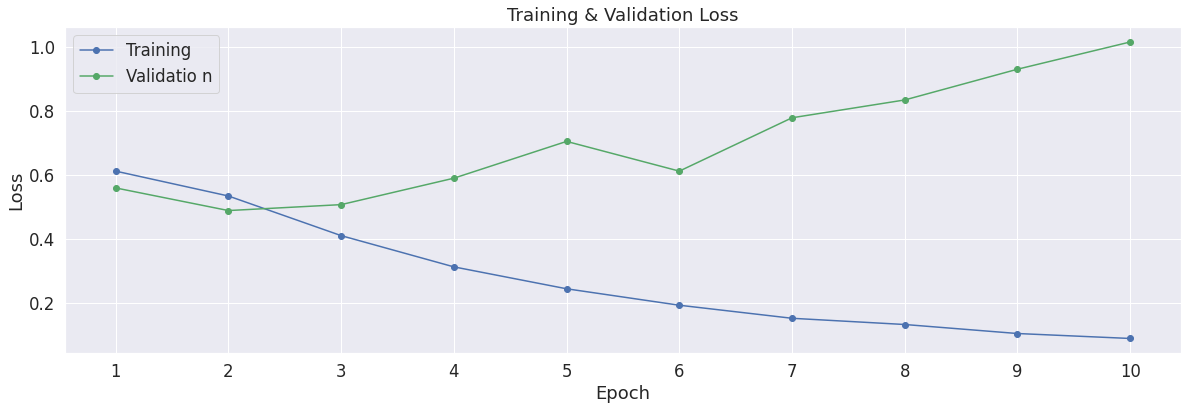

In [ ]:
pd.set_option('precision', 5)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
print(df_stats)

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validatio n")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i for i in range(1,epochs+1)])
plt.show()

Performance on Test Set

In [ ]:
out_df = test_df.rename(columns={'text':'sentence','labels':'label'})
out_df['predicted_node'] = [id2label[top_pred[i]] for i in range(len(test_df))]
out_df['predicted_node_score'] = [predictions[i][top_pred[i]] for i in range(len(test_df))]
# out_df.to_csv(f'preds/bert_sofmattressexp1.csv', columns=['sentence', 'label', 'predicted_node', 'predicted_node_score'], index=False)
print(out_df.shape)
out_df.head(10)

(837, 6)


sentence_source  label  ... predicted_node predicted_node_score
1              gj04      1  ...              1              0.99934
11             gj04      1  ...              1              0.99983
33             gj04      1  ...              1              0.99980
34             gj04      1  ...              1              0.99978
43             gj04      1  ...              1              0.99980
50             gj04      1  ...              1              0.99927
52             gj04      1  ...              1              0.99982
55             gj04      1  ...              1              0.99985
69             gj04      1  ...              1              0.78603
104            cj99      1  ...              1              0.99973

[10 rows x 6 columns]

Classification report and confusion matrix

In [ ]:
get_cr_cm(out_df['label'],out_df['predicted_node'])

              precision    recall  f1-score   support

           0       0.86      0.46      0.60       226
           1       0.83      0.97      0.89       611

    accuracy                           0.83       837
   macro avg       0.84      0.71      0.74       837
weighted avg       0.84      0.83      0.81       837



PREDICTED    0    1  All
TRUE                    
0          103  123  226
1           17  594  611
All        120  717  837

Missclassifed test docs

In [ ]:
out_df[out_df['label']!=out_df['predicted_node']].iloc[20:30].values

array([['bc01', 0, '*',
        "Although Mag doesn't eggplants, Sally eats cabbage.", 1,
        0.9997377991676331],
       ['r-67', 0, '*', "Max gave the car Levi's shove.", 1,
        0.9349764585494995],
       ['r-67', 0, '??',
        'The dumplings which Sasha is gobbling down faster than I can reheat are extremely tasty, if I do say so.',
        1, 0.9998349547386169],
       ['r-67', 0, '*',
        "The boy whose guardian's we elected employer president betrayed us.",
        1, 0.9929615259170532],
       ['r-67', 0, '*',
        "It is possible that Sam didn't pick those packages which are to be mailed tomorrow up.",
        1, 0.9972445368766785],
       ['r-67', 0, '*', 'Whether he left!', 1, 0.834621250629425],
       ['r-67', 0, '*',
        'Bill left when that no one else was awake is certain.', 1,
        0.9983853101730347],
       ['r-67', 0, '*',
        'Fluffy is sick, which that no one here realizes is certain.', 1,
        0.9994432330131531],
       ['r-67'

Sentance semantic similarity

In [8]:
pararoberta_model = SentenceTransformer('paraphrase-distilroberta-base-v2')
stsbroberta_model = SentenceTransformer('stsb-roberta-base-v2')
parampnet_model = SentenceTransformer('paraphrase-mpnet-base-v2')
stsbmpnet_model = SentenceTransformer('stsb-mpnet-base-v2')

In [9]:
sentence1 = "Isn't it a compliance issue?"
sentence2 = "Is it not a compliance issue?"

# encode sentences to get their embeddings
def encode_sents(model, sentence):
  sent_emb = model.encode(sentence, convert_to_tensor=True)
  return sent_emb

embedding1 = encode_sents(pararoberta_model, sentence1)
embedding2 = encode_sents(pararoberta_model, sentence2)

# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
print("Sentence 1:", sentence1)
print("Sentence 2:", sentence2)
print("Similarity score:", cosine_scores.item())

Sentence 1: Isn't it a compliance issue?
Sentence 2: Is it not a compliance issue?
Similarity score: 0.9450008273124695


In [10]:
embedding1 = encode_sents(parampnet_model, sentence1)
embedding2 = encode_sents(parampnet_model, sentence2)

# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
print("Sentence 1:", sentence1)
print("Sentence 2:", sentence2)
print("Similarity score:", cosine_scores.item())

Sentence 1: Isn't it a compliance issue?
Sentence 2: Is it not a compliance issue?
Similarity score: 0.9658194780349731


In [23]:
embedding1 = encode_sents(stsbroberta_model, sentence1)
embedding2 = encode_sents(stsbroberta_model, sentence2)

# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
print("Sentence 1:", sentence1)
print("Sentence 2:", sentence2)
print("Similarity score:", cosine_scores.item())

Sentence 1: Isn't it a compliance issue?
Sentence 2: Is it not a compliance issue?
Similarity score: 0.95457923412323


In [24]:
embedding1 = encode_sents(stsbmpnet_model, sentence1)
embedding2 = encode_sents(stsbmpnet_model, sentence2)

# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
print("Sentence 1:", sentence1)
print("Sentence 2:", sentence2)
print("Similarity score:", cosine_scores.item())

Sentence 1: Isn't it a compliance issue?
Sentence 2: Is it not a compliance issue?
Similarity score: 0.9460233449935913


In [54]:
sentence_pretrained_models_name = ['paraphrase-distilroberta-base-v2', 'stsb-roberta-base-v2', 'paraphrase-mpnet-base-v2', 'stsb-mpnet-base-v2']
def load_pretrained_models():
  pararoberta_model = SentenceTransformer('paraphrase-distilroberta-base-v2')
  stsbroberta_model = SentenceTransformer('stsb-roberta-base-v2')
  parampnet_model = SentenceTransformer('paraphrase-mpnet-base-v2')
  stsbmpnet_model = SentenceTransformer('stsb-mpnet-base-v2')
  return [pararoberta_model, parampnet_model, stsbmpnet_model, stsbmpnet_model]


def get_cosine_score(model, sentence1, sentence2):
  sent1_emb = model.encode(sentence1, convert_to_tensor=True)
  sent2_emb = model.encode(sentence2, convert_to_tensor=True)
  cosine_scores = util.pytorch_cos_sim(sent1_emb, sent2_emb)
  return cosine_scores

def ensemble_model_scores(sentence1, sentence2, models):
  similarity_labels = []
  agregate_result_label = "disimilar"

  for model in models:
    similarity_score = get_cosine_score(model, sentence1, sentence2)
    similarity_labels.append(round(similarity_score.item(),2))

  avg_similar_score = statistics.mean(similarity_labels)

  if avg_similar_score >= 0.4 and avg_similar_score <= 0.8:
    agregate_result_label = 'neutral'
  elif avg_similar_score > 0.8:
    agregate_result_label = 'similar'
  else:
    agregate_result_label = 'disimilar'

  return (agregate_result_label, avg_similar_score, similarity_labels)

def create_similarity_checks_structure(semantic_pred, avg_similar_score, simialry_models_score, final_pred, sentence_pretrained_models_name):
  similarity_structure = {}
  similarity_structure['similarity_check'] = final_pred
  similarity_structure['similarity_prediction'] = semantic_pred
  similarity_structure['average_similarity_score'] = avg_similar_score
  similarity_structure[sentence_pretrained_models_name[0]+'_similarity_score'] = simialry_models_score[0]
  similarity_structure[sentence_pretrained_models_name[1]+'_similarity_score'] = simialry_models_score[1]
  similarity_structure[sentence_pretrained_models_name[2]+'_similarity_score'] = simialry_models_score[2]
  similarity_structure[sentence_pretrained_models_name[3]+'_similarity_score'] = simialry_models_score[3]
  
  if avg_similar_score >= 0.4 and avg_similar_score <= 0.8:
    similarity_structure['similarity_model_threshold'] = "0.4 - 0.8"
  elif avg_similar_score > 0.8:
    similarity_structure['similarity_model_threshold'] = "> 0.8"
  else:
    similarity_structure['similarity_model_threshold'] = "< 0.4"
  return similarity_structure

def create_grammar_checks_structure(grammar_pred, grammar_model_pred, grammar_model_prob, final_pred):
  grammar_check_structure = {}
  grammar_check_structure['grammar_check'] = grammar_pred
  # grammar_check_structure['grammar_prediction'] = grammar_pred
  grammar_check_structure['grammar_xlnet_model_prediction'] = grammar_model_pred[0]
  grammar_check_structure['grammar_bert_model_prediction'] = grammar_model_pred[1]
  grammar_check_structure['grammar_xlnet_model_prediction_prob'] = grammar_model_prob[0]
  grammar_check_structure['grammar_bert_model_prediction_prob'] = grammar_model_prob[1]
  grammar_check_structure['grammar_model_threshold'] = "> = 0.5"
  grammar_check_structure['augmentation_check'] = final_pred
  return grammar_check_structure

In [6]:
max_len = 64
batch_size = 1
xlnet_tokenizer_path = "xlnet_finetuned_cola_model/"
xlnet_model_path = "xlnet_finetuned_cola_model/"
bert_tokenizer_path = "bert_finetuned_cola_model/"
bert_tokenizer_path = "bert_finetuned_cola_model/"

model_config = {'xlnet': {'task':'xlnet',
                          'model_path':'xlnet_finetuned_cola_model',
                          'tokenizer_path':'xlnet_finetuned_cola_model',
                          'max_len':64,
                          'batch_size':1},
                'bert':{'task':'bert',
                        'model_path':'bert_finetuned_cola_model',
                        'tokenizer_path':'bert_finetuned_cola_model',
                        'max_len':64,
                        'batch_size':1}
}

In [43]:
def check_gpu_availabilty():
  if torch.cuda.is_available():        
      device = torch.device("cuda")
      print('There are %d GPU(s) available.' % torch.cuda.device_count())
      print('We will use the GPU:', torch.cuda.get_device_name(0))
  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")
  return device

def get_tokenizer(task,pre_trained_model_path):
  print('Loading  tokenizer...')
  tokenizer = task.from_pretrained(pre_trained_model_path)
  return tokenizer

def load_model(task,pre_trained_model_path, classes, device):
  model = task.from_pretrained(pre_trained_model_path, num_labels = len(classes), output_attentions = False, output_hidden_states = False)
  model = model.to(device)
  return model

def create_dataloader(dataset, batch_size, Sampler):
  dataloader = DataLoader(
            dataset,
            sampler = Sampler(dataset),
            batch_size = batch_size
        )
  return dataloader

def encode_text(sent, tokenizer, max_length):
  enc = tokenizer.encode_plus(sent, add_special_tokens=True, 
                              max_length=max_length, 
                              return_tensors='pt', 
                              return_token_type_ids=False, 
                              return_attention_mask=True, 
                              pad_to_max_length=True)
  return enc

def inference(model, prediction_dataloader, device):
  model.eval() 
  predictions , top_pred = [], []
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch
    with torch.no_grad():
        result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)
    logits = result.logits
    logits = logits.detach().cpu().numpy()
    top_pred.extend(np.argmax(softmax(logits, axis=1),axis=1))
    predictions.extend(softmax(logits, axis=1))
  return top_pred, predictions

def get_all_models(config):
  models = []
  tokenizers = []
  device = check_gpu_availabilty()
  classes = ['yes','no']

  if 'xlnet' in config:
    tokenizers.append(get_tokenizer(XLNetTokenizer, config['xlnet']['tokenizer_path']))
    models.append(load_model(XLNetForSequenceClassification, config['xlnet']['model_path'],classes, device))

  if 'bert' in config:
    tokenizers.append(get_tokenizer(BertTokenizer, config['bert']['tokenizer_path']))
    models.append(load_model(BertForSequenceClassification, config['bert']['model_path'], classes, device))
  return models, tokenizers, device

def get_grammar_pred(models, tokenizers, sent, config, device):
  grammar_class_pred = []
  grammar_class_pred_prob = []
  ensemble_grammar_pred = "failed"
  id2label = {0:'no',1:'yes'}

  for i in range(0, len(models)):
    pred_model = models[i]
    pred_tokenizer = tokenizers[i]
    max_len = config['xlnet']['max_len']
    batch_size = config['xlnet']['batch_size']
    encoded_dict = encode_text(sent, pred_tokenizer, max_len)
    pred_dataloader = create_dataloader(TensorDataset(encoded_dict['input_ids'], encoded_dict['attention_mask']), batch_size, SequentialSampler)
    top_pred, predictions = inference(pred_model, pred_dataloader, device)
    grammar_class_pred.append(id2label[top_pred[0]])
    grammar_class_pred_prob.append(list(predictions[0]))

  if 'yes' in grammar_class_pred:
    ensemble_model_scores = 'passed'
  else:
    ensemble_model_scores = 'failed'
  return (ensemble_model_scores, grammar_class_pred, grammar_class_pred_prob)

In [26]:
sentence_pretrained_models = load_pretrained_models()
grammr_models, grammar_tokenizers, device = get_all_models(model_config)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loading  tokenizer...
Loading  tokenizer...


In [65]:
input_file_path = "augmentations.json"

passed_sents = []
failed_sents = []
post_processed_augemented_results = {}

with open(input_file_path) as fp:
  data = json.load(fp)
  for key, value in data.items():
    reference_sent = key
    for augmented_sent in value:
      final_pred = None
      grammar_pred = None
      similarity_pred = None
      similarity_check_struct = {}
      grammar_check_struct = {}

      # similarity check
      augmented_sent_results = ensemble_model_scores(reference_sent, augmented_sent, sentence_pretrained_models)
      aug_similarity_pred = augmented_sent_results[0]
      avg_similarity_score = augmented_sent_results[1]
      model_similarity_score = augmented_sent_results[2]

      if aug_similarity_pred == ' neutral':
        similarity_pred = 'passed'
      else:
        similarity_pred = 'failed'

      # grammar check
      grammar_pred_results = get_grammar_pred(grammr_models, grammar_tokenizers,augmented_sent,model_config, device)
      grammar_pred = grammar_pred_results[0]
      grammar_model_pred = grammar_pred_results[1]
      grammar_model_prob = grammar_pred_results[2]


      if aug_similarity_pred == 'neutral' and grammar_pred=='passed':
        final_pred = "passed"
      else:
        final_pred = "failed"
      
      if final_pred:
        similarity_check_struct = create_similarity_checks_structure(aug_similarity_pred, avg_similarity_score,model_similarity_score, similarity_pred, sentence_pretrained_models_name)
        grammar_check_struct = create_grammar_checks_structure(grammar_pred, grammar_model_pred, grammar_model_prob, final_pred)
        similarity_check_struct.update(grammar_check_struct)
      
      if final_pred and final_pred=='passed':
        passed_sents.append({'augmentation':augmented_sent,"checks":similarity_check_struct})
      else:
        failed_sents.append({'augmentation':augmented_sent,"checks":similarity_check_struct})
      break
    
    break
post_processed_augemented_results['passed'] = passed_sents
post_processed_augemented_results['failed'] = failed_sents

pprint.pprint(post_processed_augemented_results)
with open("augmentation_postprocessed_results.json", "w") as outfile: 
  json.dump(str(post_processed_augemented_results), outfile)

{'failed': [{'augmentation': 'We found the online application process to be '
                             'shady and even unorganised.',
             'checks': {'augmentation_check': 'failed',
                        'average_similarity_score': 0.26749999999999996,
                        'grammar_bert_model_prediction': 'yes',
                        'grammar_bert_model_prediction_prob': [0.0009424033,
                                                               0.99905753],
                        'grammar_check': 'passed',
                        'grammar_model_threshold': '> = 0.5',
                        'grammar_xlnet_model_prediction': 'yes',
                        'grammar_xlnet_model_prediction_prob': [0.00087130547,
                                                                0.99912876],
                        'paraphrase-distilroberta-base-v2_similarity_score': 0.24,
                        'paraphrase-mpnet-base-v2_similarity_score': 0.29,
                        

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[{'augmentation': 'The fact that we pay for compliance courses is just stupid.',
  'checks': {'average_similarity_score': 0.4325,
   'grammar_check': 'passed',
   'paraphrase-distilroberta-base-v2_similarity_score': 0.38,
   'paraphrase-mpnet-base-v2_similarity_score': 0.4,
   'similarity_check': 'passed',
   'similarity_prediction': 'neutral',
   'stsb-mpnet-base-v2_similarity_score': 0.4,
   'stsb-roberta-base-v2_similarity_score': 0.55,
   'threshold': '0.4 - 0.8'}},
 {'augmentation': 'Oh, no! Compliance training looks so good!',
  'checks': {'average_similarity_score': 0.40499999999999997,
   'grammar_check': 'passed',
   'paraphrase-distilroberta-base-v2_similarity_score': 0.58,
   'paraphrase-mpnet-base-v2_similarity_score': 0.23,
   'similarity_check': 'passed',
   'similarity_prediction': 'neutral',
   'stsb-mpnet-base-v2_similarity_score': 0.23,
   'stsb-roberta-base-v2_similarity_score': 0.58,
   'threshold': '0.4 - 0.8'}},
 {'augmentation': 'Really bad compliance training wh